In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
import pickle

In [5]:
year_2018 = pickle.load(open('historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean().reset_index()
station_mat.columns = [str(col) for col in station_mat.columns]

station_mat.head()

,date_time,72,79,82,83,116,119,120,127,128,...,3522,3523,3524,3525,3526,3527,3528,3529,3530,3629
0,2018-01-01 00:00:00,13.0,4.0,3.0,30.0,0.0,12.0,7.0,5.0,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
ts = TimeSeries.from_dataframe(station_mat.interpolate(),'date_time',['3172'])
ts

                     3172
date_time                
2018-01-01 00:00:00  26.0
2018-01-01 01:00:00  26.0
2018-01-01 02:00:00  26.0
2018-01-01 03:00:00  26.0
2018-01-01 04:00:00  26.0
...                   ...
2018-12-31 19:00:00   2.0
2018-12-31 20:00:00   2.0
2018-12-31 21:00:00   2.0
2018-12-31 22:00:00   2.0
2018-12-31 23:00:00   2.0

[8760 rows x 1 columns]
Freq: H

In [92]:
train = ts.slice(np.datetime64('2018-06-17'),np.datetime64('2018-06-30'))
valid = ts.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))

In [114]:
scaler = Scaler()
train_scl = scaler.fit_transform(train)
valid_scl = scaler.transform(valid)
ts_scl = scaler.transform(ts)

In [124]:
lstm = RNNModel(
    model='LSTM',
    output_length=1, # number of output time-steps to predict
    hidden_size=25, # Number of features in last hidden state
    n_rnn_layers=3, # Number of stacked rnn layers.
    input_length=24*7, # Number of previous time stamps taken into account.
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    log_tensorboard=True,
    random_state=1
)

lstm.fit(train_scl, val_training_series=valid_scl, verbose=True)

Training loss: 0.0170, validation loss: 0.0635


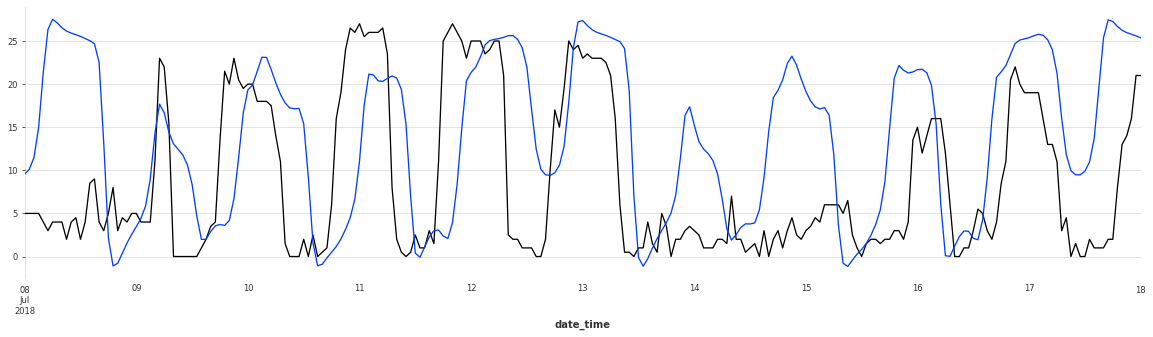

In [125]:
forecast = scaler.inverse_transform(lstm.predict(n=24*22))
plt.figure(figsize=(20,5))
ts.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18')).plot()
forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18')).plot()

In [126]:
print('RMSE: ', rmse(valid,forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))))

RMSE:  11.648948693251773
